In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
import gym
import gym_combrf

import numpy as np
import random
import math
import matplotlib.pyplot as plt
import tqdm
import os

import torch
import torch.optim as optim
import torch.nn.functional as F




In [30]:
#initialize gym environment
env = gym.make('combrf-v0')

In [31]:
#hyper-parameters
UPDATE_EVERY = 50 #how often to update the network
EPS_START = 1
EPS_END = 0.01
EPS_DECAY = 0.9983
EPS_STEP_LIMIT = 50

TRAIN_EPISODES = 20
TEST_EPISODES = 1
seed = 0

#initialize GPU device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


## Examine state and action spaces

In [32]:
#reset the environment
obs = env.reset()

#size of each action
action_size = env.action_space.shape
print("Size of each action: ", action_size)

#size of observation
print("Size of each observation: ", obs.shape)
print("Observation looks like:")
print(obs)

Size of each action:  (1,)
Size of each observation:  (130,)
Observation looks like:
[ 1.73256983e-07 -1.80579883e-07  1.38786131e-07 -5.92433789e-08
 -3.64132191e-08  1.22165639e-07 -1.74689733e-07  1.79699261e-07
 -1.80579883e-07  1.38786131e-07 -5.92433789e-08 -3.64132191e-08
  1.22165639e-07 -1.74689733e-07  1.79699261e-07 -1.35831662e-07
  1.38786131e-07 -5.92433789e-08 -3.64132191e-08  1.22165639e-07
 -1.74689733e-07  1.79699261e-07 -1.35831662e-07  5.50186604e-08
 -5.92433789e-08 -3.64132191e-08  1.22165639e-07 -1.74689733e-07
  1.79699261e-07 -1.35831662e-07  5.50186604e-08  4.07590887e-08
 -3.64132191e-08  1.22165639e-07 -1.74689733e-07  1.79699261e-07
 -1.35831662e-07  5.50186604e-08  4.07590887e-08 -1.25450609e-07
  1.22165639e-07 -1.74689733e-07  1.79699261e-07 -1.35831662e-07
  5.50186604e-08  4.07590887e-08 -1.25450609e-07  1.76020311e-07
 -1.74689733e-07  1.79699261e-07 -1.35831662e-07  5.50186604e-08
  4.07590887e-08 -1.25450609e-07  1.76020311e-07 -1.78713538e-07
  1.7

## Perform random actions in the environment

In [33]:
obs = env.reset()
count = 0
ep_rwd=0
rewards =[]
while True:
    action = np.array([round(np.random.uniform(0,2*math.pi), 2)])
    obs, rwd, done, _ = env.step(action)
    ep_rwd += rwd
    rewards.append(rwd)
    count +=1
    if done:
        break
print("Random TX location: {0}".format(env.tx_loc))
print("Capacity: {0}".format(env.cap))
print("Episodic score: {0} with episode length: {1} ".format(ep_rwd, count))
print(rewards)

Random TX location: [[300 500   0]]
Capacity: 4.4765235164622934e-08
Episodic score: 1.5 with episode length: 8 
[0.3, 0.3, 0.0, 0.3, 0.0, 0.0, 0.3, 0.3]


## Instantiate DDPG agent

In [34]:
#import custom classes
from Source.ddpg_rcv_agent import Agent
from Source.nn_model import Actor, Critic
from Source.ddpg_rcv_agent import Agent, ReplayBuffer, OUNoise
from collections import deque

#reset the environment
obs = env.reset()

state_size = obs.shape[0]
action_size = env.action_space.shape[0]
print(action_size)
#instantiate the agent
agent = Agent(state_size=state_size, action_size=action_size, seed=0)

print(type(obs))
obs_tensor = torch.from_numpy(obs).float().to(device)
print(obs_tensor)

1
<class 'numpy.ndarray'>
tensor([-1.7172e-07,  2.0865e-07, -1.9890e-07,  1.4464e-07, -5.8026e-08,
        -4.1571e-08,  1.3187e-07, -1.9266e-07,  2.0865e-07, -1.9890e-07,
         1.4464e-07, -5.8026e-08, -4.1571e-08,  1.3187e-07, -1.9266e-07,
         2.1035e-07, -1.9890e-07,  1.4464e-07, -5.8026e-08, -4.1571e-08,
         1.3187e-07, -1.9266e-07,  2.1035e-07, -1.8098e-07,  1.4464e-07,
        -5.8026e-08, -4.1571e-08,  1.3187e-07, -1.9266e-07,  2.1035e-07,
        -1.8098e-07,  1.1111e-07, -5.8026e-08, -4.1571e-08,  1.3187e-07,
        -1.9266e-07,  2.1035e-07, -1.8098e-07,  1.1111e-07, -1.6391e-08,
        -4.1571e-08,  1.3187e-07, -1.9266e-07,  2.1035e-07, -1.8098e-07,
         1.1111e-07, -1.6391e-08, -8.1999e-08,  1.3187e-07, -1.9266e-07,
         2.1035e-07, -1.8098e-07,  1.1111e-07, -1.6391e-08, -8.1999e-08,
         1.6204e-07, -1.9266e-07,  2.1035e-07, -1.8098e-07,  1.1111e-07,
        -1.6391e-08, -8.1999e-08,  1.6204e-07, -2.0583e-07, -1.2215e-07,
         2.9562e-08,  6.9

## DDPG Training

Episode 100	Average Score: 2.05
Episode 200	Average Score: 2.19
Episode 300	Average Score: 2.21
Episode 400	Average Score: 2.19
Episode 500	Average Score: 2.19
Episode 600	Average Score: 2.25
Episode 700	Average Score: 2.22
Episode 800	Average Score: 2.22


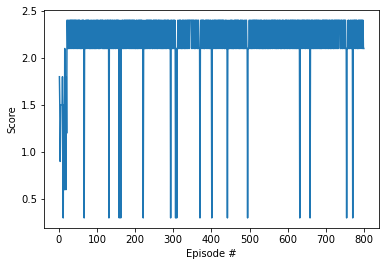

In [35]:
train_episodes = 800
print_every= 100

scores_deque = deque(maxlen=print_every)
scores = []

for i_episode in range(1,train_episodes+1):
    
    # reset the environment
    obs = env.reset()
    agent.reset()
    ep_rwds = []
    score = 0
    while True:
        action = agent.act(obs)
        next_obs, reward, done, _ = env.step(action)
        agent.step(obs, action, reward, next_obs, done)
        obs = next_obs
        score+= reward
        ep_rwds.append(reward)
        if done:
            break
            
    scores_deque.append(score)
    scores.append(score)
    #print('\rEpisode {}\t, TX loc: {}\t, Score: {:.2f}\n'.format(i_episode, env.tx_loc, score), end="")
    
    #print(ep_rwds)
    if i_episode % print_every == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
    
torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')    
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show() 

## Testing the DDPG agent

In [58]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

score = 0.0
eps_rwd =[]
obs = env.reset()
agent.actor_local.eval()
agent.critic_local.eval()
ep_actions =[]
while True:
    #obs_tensor = torch.from_numpy(obs).float().to(device)
    
    action =  agent.act(obs,add_noise=False)#.cpu().data.numpy()
    #action == np.clip(action, 0, 2*np.pi)
    
    #action_tensor = agent.actor_local(obs_tensor).to(device)
    #print(obs, action)
    #q_val = agent.critic_local(obs_tensor, action_tensor).cpu().data.numpy()
    obs, rwd, done, _ = env.step(action)
    ep_actions.append(action)
    score +=rwd
    eps_rwd.append(rwd)
    if done:
        break
print("TX loc: {0}, episode score: {1}\n".format(env.tx_loc, score))
print("TX_beam dir: {}".format(env.tx_beam))
print("eps rwds: {}\n".format(eps_rwd))
print("Applied RX directions: {}".format(ep_actions))

TX loc: [[300 350   0]], episode score: 2.4

TX_beam dir: [ 1.        +0.j         -0.70710678-0.70710678j  0.        +1.j
  0.70710678-0.70710678j -1.        +0.j          0.70710678+0.70710678j
  0.        -1.j         -0.70710678+0.70710678j]
eps rwds: [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3]

Applied RX directions: [array([6.2831855], dtype=float32), array([6.2831855], dtype=float32), array([6.2831855], dtype=float32), array([6.2831855], dtype=float32), array([6.2831855], dtype=float32), array([6.2831855], dtype=float32), array([6.2831855], dtype=float32), array([6.2831855], dtype=float32)]
